# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Import libraries
import torch
import json
import torch.nn.functional as F
import numpy as np
from torch import nn
from torchvision import datasets, transforms, models
from collections import OrderedDict
from workspace_utils import active_session
from PIL import Image
from matplotlib import pyplot as plt

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# Assign folder names
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define transforms for the training, validation and testing sets

# Augement training data with random transformations
train_data_transforms = transforms.Compose([
                                            transforms.Resize((224,224)),                # Resize images, as required by pre-trained networks
                                            transforms.RandomHorizontalFlip(),           # Randomly flip images horizontally with default p=0.5
                                            transforms.RandomVerticalFlip(),             # Randomly flip images vertically with default p=0.5
                                            transforms.RandomRotation(degrees=(20,60)),  # Randomly rotate image between 20 and 60 degrees
                                            transforms.ToTensor(),                       # Transform image to a tensor
                                            # Normalise color channels as per ImageNet training images
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                           ])

# Transform validation data to align with training data, without augmentation
valid_data_transforms = transforms.Compose([
                                            transforms.Resize((224,224)),                # Resize images, as required by pre-trained networks
                                            transforms.ToTensor(),                       # Transform image to a tensor
                                            # Normalise color channels as per ImageNet training images
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                           ])

# Transform test data to align with training data, without augmentation
test_data_transforms = transforms.Compose([
                                           transforms.Resize((224,224)),                # Resize images, as required by pre-trained networks
                                           transforms.ToTensor(),                       # Transform image to a tensor
                                           # Normalise color channels as per ImageNet training images
                                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                          ])

# Load the datasets 
train_image_dataset = datasets.ImageFolder(train_dir, transform=train_data_transforms)
valid_image_dataset = datasets.ImageFolder(valid_dir, transform=valid_data_transforms)
test_image_dataset = datasets.ImageFolder(test_dir, transform=test_data_transforms)

# Define dataloaders
train_dataloader = torch.utils.data.DataLoader(train_image_dataset, batch_size=64, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_image_dataset, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_image_dataset, batch_size=32)

In [4]:
# Display train, validation and test dataset properties
print(train_image_dataset)
print(valid_image_dataset)
print(test_image_dataset)

Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: flowers/train
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             RandomVerticalFlip(p=0.5)
                             RandomRotation(degrees=(20, 60), resample=False, expand=False)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 818
    Root Location: flowers/valid
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if an

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(len(cat_to_name))
print(cat_to_name)

102
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54'

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [6]:
# Build and train your network

# Load pre-trained model
model = models.vgg13(pretrained=True)

# Display model architecture
print(model)

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.torch/models/vgg13-c768596a.pth
100%|██████████| 532194478/532194478 [00:08<00:00, 61522547.40it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(inplace)
    (17): Conv2d

In [6]:
# Define a new classifier to replace the classifier in the pre-trained model,
# with an arbitrary number of hidden layers and drop out between the layers
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
           Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(p=drop_p)
    
    # Define forward pass function, which returns log-softmax, applying ReLU activation
    # function and droupout at each hidden layer
    def forward(self, x):
        
        # Loop through hidden layers, applying ReLU activation function and drop out
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        # Generate and return output
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)
        

In [8]:
# Freeze parameters of pre-trained model above so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Instantiate feed forward classifier and assign it to classification component of pre-trained model
input_size = 25088
hidden_layers = [512, 256]
output_size = 102
classifier = Network(input_size, output_size, hidden_layers)
model.classifier = classifier

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(inplace)
    (17): Conv2d

In [9]:
# Set device to CUDA, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Define loss criterion and optimiser
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)


In [7]:
# Train and view loss and accuracy on validation set

# Define a validation function to be called while training a model
# This validation function will return the loss and accuracy of the model on a validation dataset
def validation(model, validation_dataloader, criterion):
    
    # Initialise test loss and accuracy 
    test_loss = 0
    test_accuracy = 0
    
    # Grab batches of (images, labels) from validation dataloader and forward pass through model
    for (images, labels) in iter(validation_dataloader):
        
        # Move images and labels to device
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        # Increment test_loss and test_accuracy for batch of validation data
        test_loss += criterion(outputs, labels).item()
        
        # Calculate probabilities for log-softmax output, and correct predictions
        ps = torch.exp(outputs)
        correct_preds = (labels.data == ps.max(dim=1)[1])
        test_accuracy += correct_preds.type(torch.FloatTensor).mean()
        
    return test_loss, test_accuracy


# Define function to train a deep learning model and display the loss and accuracy on a validation test set
# This function will return the trained model
def train_and_validate_model(model, epochs=5, print_every=25):  
    
    # Initialise training_step and running _loss values
    training_step = 0
    running_loss = 0

    for epoch in range (epochs):

        # Set model to training mode
        model.train()

        # Grab batches of (images, labels) from training dataloader
        for (images, labels) in iter(train_dataloader):
            # Move inputs and labels to device
            images, labels = images.to(device), labels.to(device)

            training_step += 1                                  # Increment training step counter
            optimizer.zero_grad()                               # Zero gradients to avoid accumulation of quantities
            outputs = model.forward(images)                     # Forwrard pass through model
            loss = criterion(outputs, labels)                   # Calculate the loss
            loss.backward()                                     # Perform backward pass
            optimizer.step()                                    # Update weights
            running_loss += loss.item()                         # Accumulate running loss with each training step

            # Display loss and accuracy metrics on training and validation datasets
            if training_step % print_every == 0:
                # Set model to evaluation mode, to switch off drop out for evaluation
                model.eval()
                # Turn off gradient calculation to speed up predictions
                with torch.no_grad():
                    val_loss, val_acc = validation(model, valid_dataloader, criterion)
                    print(f'Epoch {epoch+1}/{epochs}: Training loss = {running_loss/print_every}, Validation loss = {val_loss/len(valid_dataloader)}, Validation accuracy = {val_acc/len(valid_dataloader)}')

                running_loss = 0

                # Set model back to training mode
                model.train()
                
    return model
                              

In [11]:
# Run training iteration
with active_session():
    train_and_validate_model(model, epochs=8)

Epoch 1/8: Training loss = 4.623028984069824, Validation loss = 4.142818900255056, Validation accuracy = 0.16225960850715637
Epoch 1/8: Training loss = 4.098925313949585, Validation loss = 3.6402792105307946, Validation accuracy = 0.24038460850715637
Epoch 1/8: Training loss = 3.6087091541290284, Validation loss = 3.0768557832791257, Validation accuracy = 0.3365384638309479
Epoch 1/8: Training loss = 3.223994073867798, Validation loss = 2.7315602348401, Validation accuracy = 0.36752134561538696
Epoch 2/8: Training loss = 2.801967535018921, Validation loss = 2.302126109600067, Validation accuracy = 0.4724893271923065
Epoch 2/8: Training loss = 2.5921921634674074, Validation loss = 2.0487338258669925, Validation accuracy = 0.49145299196243286
Epoch 2/8: Training loss = 2.5066689682006835, Validation loss = 2.0358648884754915, Validation accuracy = 0.4941239356994629
Epoch 2/8: Training loss = 2.356133909225464, Validation loss = 1.8594865277409554, Validation accuracy = 0.532318353652954

Validation accuracy in the model above is around 72% - pretty good!

In [8]:
# Define function to build and return an untrained model, along with criterion and optimizer
# This function allows different hidden layer architectures for the classifier to be easily tested
def return_model_crit_optim(hidden_layers, input_size=25088, output_size=102, model=models.vgg13(pretrained=True), lr=0.001, drop_p=0.5):
    
    # Freeze parameters of pre-trained model above so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    
    # Instantiate feed forward classifier and assign it to classification component of pre-trained model
    classifier = Network(input_size, output_size, hidden_layers, drop_p)
    model.classifier = classifier
    #print(model)

    # Set device to CUDA, if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Move model to device
    model = model.to(device)

    # Define loss criterion and optimiser
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=lr)
    
    return model, criterion, optimizer

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.torch/models/vgg13-c768596a.pth
100%|██████████| 532194478/532194478 [00:09<00:00, 56996084.70it/s]


In [14]:
# Test an arhcitecture with an additional hidden layer in the classification model

# Assign model (with classifier with hidden_layers=[1024, 512, 256]), criterion and optimizer 
model, criterion, optimizer = return_model_crit_optim([1024, 512, 256])

# Run training iteration for 5 epochs
with active_session():
    trained_model = train_and_validate_model(model, epochs=5)

Epoch 1/5: Training loss = 4.716979389190674, Validation loss = 4.5253490301278925, Validation accuracy = 0.06730769574642181
Epoch 1/5: Training loss = 4.468610401153565, Validation loss = 4.291364981577947, Validation accuracy = 0.10817307978868484
Epoch 1/5: Training loss = 4.218159875869751, Validation loss = 3.91138324370751, Validation accuracy = 0.15985576808452606
Epoch 1/5: Training loss = 3.9041942310333253, Validation loss = 3.4779705817882833, Validation accuracy = 0.22716346383094788
Epoch 2/5: Training loss = 3.6467237281799316, Validation loss = 3.1436604719895582, Validation accuracy = 0.28725960850715637
Epoch 2/5: Training loss = 3.2804580688476563, Validation loss = 2.737714538207421, Validation accuracy = 0.34495192766189575
Epoch 2/5: Training loss = 3.0948938083648683, Validation loss = 2.5450818630365224, Validation accuracy = 0.3822115361690521
Epoch 2/5: Training loss = 2.8466397762298583, Validation loss = 2.4061085237906528, Validation accuracy = 0.3855502009

Training and validation loss continue to decrease.  Will increase number of epochs in next test.

In [54]:
# This time increase epochs from 5 to 8

# Assign model (with classifier with hidden_layers=[1024, 512, 256]), criterion and optimizer 
model, criterion, optimizer = return_model_crit_optim([1024, 512, 256])

# Run training iteration for 8 epochs
with active_session():
    trained_model = train_and_validate_model(model, epochs=8)

Epoch 1/8: Training loss = 4.7267304801940915, Validation loss = 4.508915240948017, Validation accuracy = 0.05889423191547394
Epoch 1/8: Training loss = 4.498861904144287, Validation loss = 4.334446870363676, Validation accuracy = 0.109375
Epoch 1/8: Training loss = 4.26460036277771, Validation loss = 3.9229460587868323, Validation accuracy = 0.15745192766189575
Epoch 1/8: Training loss = 3.983147783279419, Validation loss = 3.507446417441735, Validation accuracy = 0.24879807233810425
Epoch 2/8: Training loss = 3.647063636779785, Validation loss = 3.181099832057953, Validation accuracy = 0.3257211446762085
Epoch 2/8: Training loss = 3.2866342639923096, Validation loss = 2.9501503155781674, Validation accuracy = 0.32545405626296997
Epoch 2/8: Training loss = 3.1086491775512695, Validation loss = 2.56155893435845, Validation accuracy = 0.37620192766189575
Epoch 2/8: Training loss = 2.8948411083221437, Validation loss = 2.3670248847741346, Validation accuracy = 0.3999732732772827
Epoch 3/

Training and validation loss continuing to decrease, will increase number of epochs again in the next test.

In [56]:
# This time increase epochs from 8 to 12
# Assign model (with classifier with hidden_layers=[1024, 512, 256]), criterion and optimizer 
model, criterion, optimizer = return_model_crit_optim([1024, 512, 256], lr=0.001)

# Run training iteration for 12 epochs
with active_session():
    trained_model = train_and_validate_model(model, epochs=12)

Epoch 1/12: Training loss = 4.710970020294189, Validation loss = 4.506147916500385, Validation accuracy = 0.09855769574642181
Epoch 1/12: Training loss = 4.442628860473633, Validation loss = 4.267224394358122, Validation accuracy = 0.09855769574642181
Epoch 1/12: Training loss = 4.181761093139649, Validation loss = 3.9129583835601807, Validation accuracy = 0.14423076808452606
Epoch 1/12: Training loss = 3.9221385097503663, Validation loss = 3.541625032058129, Validation accuracy = 0.21274039149284363
Epoch 2/12: Training loss = 3.561835222244263, Validation loss = 3.151955783367157, Validation accuracy = 0.3016826808452606
Epoch 2/12: Training loss = 3.31372971534729, Validation loss = 2.915412370975201, Validation accuracy = 0.32211539149284363
Epoch 2/12: Training loss = 3.1336015319824218, Validation loss = 2.6713729821718655, Validation accuracy = 0.36298078298568726
Epoch 2/12: Training loss = 2.8758790493011475, Validation loss = 2.465312347962306, Validation accuracy = 0.3999732

In [55]:
# Test same model architecture with 8 epochs, but 'faster' learning rate

# Assign model (with classifier with hidden_layers=[1024, 512, 256]), criterion and optimizer 
model, criterion, optimizer = return_model_crit_optim([1024, 512, 256], lr=0.01)

# Run training iteration for 5 epochs
with active_session():
    trained_model = train_and_validate_model(model, epochs=8)

Epoch 1/8: Training loss = 8.990670127868652, Validation loss = 4.9928878637460565, Validation accuracy = 0.02764423005282879
Epoch 1/8: Training loss = 4.658348560333252, Validation loss = 4.575221410164466, Validation accuracy = 0.030048076063394547
Epoch 1/8: Training loss = 4.640911502838135, Validation loss = 4.543034186730018, Validation accuracy = 0.030048076063394547
Epoch 1/8: Training loss = 4.564454174041748, Validation loss = 4.465343209413382, Validation accuracy = 0.045673076063394547
Epoch 2/8: Training loss = 4.7168288230896, Validation loss = 4.529000786634592, Validation accuracy = 0.02524038404226303
Epoch 2/8: Training loss = 4.705690326690674, Validation loss = 4.515331772657541, Validation accuracy = 0.03365384787321091
Epoch 2/8: Training loss = 4.5499584770202635, Validation loss = 4.516756057739258, Validation accuracy = 0.03365384787321091
Epoch 2/8: Training loss = 4.531744022369384, Validation loss = 4.484102909381573, Validation accuracy = 0.033653847873210

Training loss reductions stagnated.  Suggests the learning rate is too big and that gradient descent has found a 'poor' local minimum.  It may be good to try momentum to 'push' beyond this or a decaying learning rate.

In [15]:
# Reduce learning rate back to 0.001 and test with an additional hidden layer and 12 epochs
# Assign model (with classifier with hidden_layers=[2048, 1024, 512, 256]), criterion and optimizer 
model, criterion, optimizer = return_model_crit_optim([2048, 1024, 512, 256], lr=0.001)

# Run training iteration for 5 epochs
with active_session():
    trained_model = train_and_validate_model(model, epochs=12)

Epoch 1/12: Training loss = 4.687090892791748, Validation loss = 4.549595190928533, Validation accuracy = 0.02524038404226303
Epoch 1/12: Training loss = 4.5594802093505855, Validation loss = 4.499180647043081, Validation accuracy = 0.026442307978868484
Epoch 1/12: Training loss = 4.425188827514648, Validation loss = 4.268875809816214, Validation accuracy = 0.07932692021131516
Epoch 1/12: Training loss = 4.289968681335449, Validation loss = 4.004130849471459, Validation accuracy = 0.13942307233810425
Epoch 2/12: Training loss = 4.016842164993286, Validation loss = 3.651405985538776, Validation accuracy = 0.15745192766189575
Epoch 2/12: Training loss = 3.8031083297729493, Validation loss = 3.425863307255965, Validation accuracy = 0.18269230425357819
Epoch 2/12: Training loss = 3.639615926742554, Validation loss = 3.247878345159384, Validation accuracy = 0.24158653616905212
Epoch 2/12: Training loss = 3.473620672225952, Validation loss = 3.086068203816047, Validation accuracy = 0.2283653

This is taking longer to train.  Will reduce number of layers to speed up training time.

In [120]:
# Try different pre-trained vgg model and run for 20 epochs

# Assign model (with classifier with hidden_layers=[1024, 512, 256]), criterion and optimizer 
model, criterion, optimizer = return_model_crit_optim([1024, 512, 256], input_size=25088, model=models.vgg11(pretrained = True), lr=0.001)


# Run training iteration for 20 epochs
with active_session():
    trained_model = train_and_validate_model(model, epochs=20)

Epoch 1/20: Training loss = 4.669578609466552, Validation loss = 4.517259029241709, Validation accuracy = 0.07451923191547394
Epoch 1/20: Training loss = 4.493639316558838, Validation loss = 4.3632208200601434, Validation accuracy = 0.11177884787321091
Epoch 1/20: Training loss = 4.262972564697265, Validation loss = 4.035174113053542, Validation accuracy = 0.14423076808452606
Epoch 1/20: Training loss = 3.9826497268676757, Validation loss = 3.603827247252831, Validation accuracy = 0.20793269574642181
Epoch 2/20: Training loss = 3.6611094093322754, Validation loss = 3.194828267280872, Validation accuracy = 0.24278846383094788
Epoch 2/20: Training loss = 3.362384614944458, Validation loss = 2.8576340629504275, Validation accuracy = 0.3353365361690521
Epoch 2/20: Training loss = 3.106213426589966, Validation loss = 2.657133455459888, Validation accuracy = 0.34468480944633484
Epoch 2/20: Training loss = 2.8836391258239744, Validation loss = 2.613559617446019, Validation accuracy = 0.365785

I'm happy with this validation accuracy, but will experiment with different drop_out probabilities now to see if I can achieve a similar accuracy with less epochs.

In [19]:
# Try same model above, but with drop_out reduced from 0.5 to 0.4 and run for 12 epochs

# Assign model (with classifier with hidden_layers=[1024, 512, 256]), criterion and optimizer 
model, criterion, optimizer = return_model_crit_optim([1024, 512, 256], input_size=25088, model=models.vgg11(pretrained = True), lr=0.001, drop_p=0.4)


# Run training iteration for 20 epochs
with active_session():
    trained_model = train_and_validate_model(model, epochs=12)

Epoch 1/12: Training loss = 4.621596622467041, Validation loss = 4.40738635796767, Validation accuracy = 0.08774038404226303
Epoch 1/12: Training loss = 4.3052629947662355, Validation loss = 4.000203747015733, Validation accuracy = 0.13942307233810425
Epoch 1/12: Training loss = 3.823581380844116, Validation loss = 3.398208063382369, Validation accuracy = 0.27163460850715637
Epoch 1/12: Training loss = 3.3132666969299316, Validation loss = 2.7655992255761075, Validation accuracy = 0.34375
Epoch 2/12: Training loss = 2.8055405902862547, Validation loss = 2.4639463745630703, Validation accuracy = 0.3725961446762085
Epoch 2/12: Training loss = 2.6148093128204346, Validation loss = 2.1561431953540215, Validation accuracy = 0.46340811252593994
Epoch 2/12: Training loss = 2.3846426677703856, Validation loss = 2.0298494908672113, Validation accuracy = 0.48237180709838867
Epoch 2/12: Training loss = 2.153617205619812, Validation loss = 1.8115960978544676, Validation accuracy = 0.49118587374687

Achieving higher accuracy on the validation set with fewer epochs.  Will test with lower drop_out probability to see if I can get more improvements.

In [17]:
# Test same model above with drop_out=0.3

# Assign model (with classifier with hidden_layers=[1024, 512, 256]), criterion and optimizer 
model, criterion, optimizer = return_model_crit_optim([1024, 512, 256], input_size=25088, \
                                                      model=models.vgg11(pretrained = True), lr=0.001, drop_p=0.3)


# Run training iteration for 20 epochs
with active_session():
    trained_model = train_and_validate_model(model, epochs=12)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.torch/models/vgg11-bbd30ac9.pth
100%|██████████| 531456000/531456000 [00:31<00:00, 16767760.16it/s]


Epoch 1/12: Training loss = 4.519360103607178, Validation loss = 4.238326696249155, Validation accuracy = 0.09375
Epoch 1/12: Training loss = 3.9723241996765135, Validation loss = 3.4583162711216855, Validation accuracy = 0.26201921701431274
Epoch 1/12: Training loss = 3.1594634819030762, Validation loss = 2.7644140857916613, Validation accuracy = 0.36899039149284363
Epoch 1/12: Training loss = 2.617847900390625, Validation loss = 2.300819442822383, Validation accuracy = 0.4441773295402527
Epoch 2/12: Training loss = 2.216298108100891, Validation loss = 2.025785274230517, Validation accuracy = 0.4871794879436493
Epoch 2/12: Training loss = 1.929658055305481, Validation loss = 1.7972621424840047, Validation accuracy = 0.5287126302719116
Epoch 2/12: Training loss = 1.7370446968078612, Validation loss = 1.6968183334057148, Validation accuracy = 0.5464743375778198
Epoch 2/12: Training loss = 1.6668217420578002, Validation loss = 1.5546541810035706, Validation accuracy = 0.5936164259910583


Achieved higher accuracy again.  Will conduct one last experiment on drop_out probability.

In [21]:
# Try same model above, but with drop_out changed to 0.35 and run for 12 epochs

# Assign model (with classifier with hidden_layers=[1024, 512, 256]), criterion and optimizer 
model, criterion, optimizer = return_model_crit_optim([1024, 512, 256], input_size=25088, \
                                                      model=models.vgg11(pretrained = True), lr=0.001, drop_p=0.35)


# Run training iteration for 20 epochs
with active_session():
    trained_model_test = train_and_validate_model(model, epochs=12)

Epoch 1/12: Training loss = 4.569400596618652, Validation loss = 4.373938514636113, Validation accuracy = 0.07091346383094788
Epoch 1/12: Training loss = 4.097733364105225, Validation loss = 3.695674318533677, Validation accuracy = 0.21033653616905212
Epoch 1/12: Training loss = 3.4035870265960693, Validation loss = 2.8520486125579247, Validation accuracy = 0.3402777910232544
Epoch 1/12: Training loss = 2.835341386795044, Validation loss = 2.3947111872526317, Validation accuracy = 0.3874198794364929
Epoch 2/12: Training loss = 2.2995554113388064, Validation loss = 2.1481080376184902, Validation accuracy = 0.4537927210330963
Epoch 2/12: Training loss = 2.155980544090271, Validation loss = 1.9034724143835215, Validation accuracy = 0.5227029919624329
Epoch 2/12: Training loss = 2.0568893337249756, Validation loss = 1.743995162156912, Validation accuracy = 0.544738233089447
Epoch 2/12: Training loss = 1.924292140007019, Validation loss = 1.542106453042764, Validation accuracy = 0.601762831

Validation accuracy is good, however the training loss is almost half (how much more is too more?!  There is no definitive position on this!) that of the validation loss.  I would have thought this would suggest over fitting, but the validation accuracy is good.  In cases like this what I might want to experiment a bit more with my parameters. If things improve, great! If they don't, but I still have a good accuracy on my validation set, then I can move on!

<b>I'm happy with this model and will use this in the following exercises.</b>

In [22]:
trained_model_test

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
# Do validation on the test set

# Define function to calculate and display model accuracy on test dataset
def check_accuracy_on_test(model, testloader, device):    
    correct_count, all_count = 0, 0
    
    # Switch of gradient calculations to speed up calculations
    with torch.no_grad():
        for (images, labels) in iter(testloader):
            
            # Move input and label tensors to the GPU
            images, labels = images.to(device), labels.to(device)
            
            # Generate predicted probabilities
            pred_probs = torch.exp(model(images))
            
            # Assign max probability and predicted class
            max_prob, predicted = torch.max(pred_probs.data, 1)
            all_count += labels.size(0)
            correct_count += (predicted == labels).sum().item()

    print(f'Model accuracy on {all_count} test images: {round((100 * correct_count / all_count),2)}%')

In [24]:
# Set model to evalution mode to switch off drop out and calculate accuracy on test data
trained_model_test.eval()
check_accuracy_on_test(trained_model_test, test_dataloader, device)

Model accuracy on 819 test images: 74.11%


The model has generalised well to unseen data!  I'm happy with this!

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [26]:
# Assign class_to_idx mapping as an attribute of the trained model
trained_model_test.class_to_idx = train_image_dataset.class_to_idx

In [27]:
# Save checkpoint of trained model

# Create a dictionary of paramaters required to rebuild model

checkpoint = {'input_size':25088,
              'output_size':102,
              'hidden_layers':[each.out_features for each in trained_model_test.classifier.hidden_layers],
              'lr':0.001,
              'drop_rate':trained_model_test.classifier.dropout.p,
              'epochs':12,
              'arch':'vgg11',
              'classifier': trained_model_test.classifier,
              'state_dict':trained_model_test.state_dict(),
              'optimizer': optimizer.state_dict(),
              'class_to_idx_map': trained_model_test.class_to_idx}


# Save model architecture to .pth file
torch.save(checkpoint, 'checkpoint.pth')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [10]:
cp = torch.load('checkpoint.pth')
cp.keys()

dict_keys(['input_size', 'output_size', 'hidden_layers', 'lr', 'drop_rate', 'epochs', 'arch', 'classifier', 'state_dict', 'optimizer', 'class_to_idx_map'])

In [11]:
# Set device to CUDA, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define function to load checkpoint file and return previously trained model along with checkpoint parameters
def load_checkpoint(filepath):
    
    cp = torch.load(filepath)
    
    if cp['arch'] == 'vgg11':
        model = models.vgg11(pretrained = True)
    
    # Freeze parameters of pre-trained model above so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    
    # Assign classifier component of pre-trained model
    model.classifier = cp['classifier']
    
    # Assign previously trained model paramaters
    model.load_state_dict(cp['state_dict'])
    
    # Move model to device
    model = model.to(device)
   
    return model, cp

In [12]:
# Load and assign model, along with checkpoint paramaters for future reference
model, cp = load_checkpoint('checkpoint.pth')

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.torch/models/vgg11-bbd30ac9.pth
100%|██████████| 531456000/531456000 [00:05<00:00, 90445334.05it/s] 


In [13]:
# Verify successful save/load of model checpoint by re-calculating accuracy on test set 
# and confirming it's consistent with previous result
check_accuracy_on_test(model, test_dataloader, device)

Model accuracy on 819 test images: 74.11%


<b>Accuracy of the loaded model reconciles with the run above.  Model has been successfully saved and loaded.</b>

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

(667, 500)


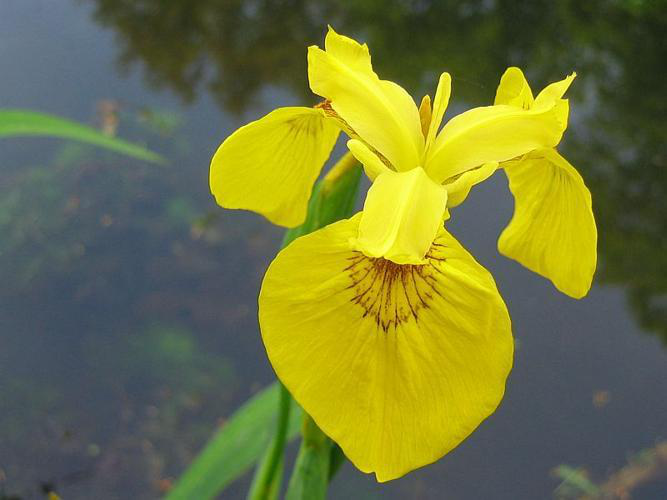

In [32]:
# Display an image
img = Image.open(train_dir+'/15/image_06355.jpg')
print(img.size)
img

In [15]:
# Define function to return resized image such that shortest side is 256 pixels, as per instructions above
# and the image's aspect ratio is retained
def return_resized_img(img, min_dim=256):

    # Get image dimensions
    img_width, img_height = img.size

    # Calculate scaled heights and widths    
    if img_height <= img_width:
        scaling_factor = min_dim / img_height
        scaled_height = int(scaling_factor * img_height)
        scaled_width = int(scaling_factor * img_width) 
    else: 
        scaling_factor = min_dim / img_width
        scaled_height = int(scaling_factor * img_height)
        scaled_width = int(scaling_factor * img_width)

    # Return resized image, with scaled width and height    
    return img.resize((scaled_width, scaled_height))


# Define function to return coordinates of box required for cropping
def find_center_crop_coords(img, new_width=224, new_height=224):

    # Get image dimensions
    img_width, img_height = img.size   

    # Calculate borders
    left = (img_width - new_width)/2
    top = (img_height - new_height)/2
    right = (img_width + new_width)/2
    bottom = (img_height + new_height)/2

    # Return coordinates of cropped box borders
    return left, top, right, bottom

# Test functions above
img = Image.open(train_dir+'/15/image_06355.jpg')

# Create resized and cropped versions of image
img_resized = return_resized_img(img)
img_cropped = img_resized.crop((find_center_crop_coords(img_resized)))

# Convert cropped image to a numpy array
np_image = np.array(img_cropped)

# Scale values between 0 and 1
np_image = np_image / 255

# Normalise values in same way as training data
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
np_image = (np_image-mean)/std

np_image = np_image.transpose()
print(np_image.shape)

(3, 224, 224)


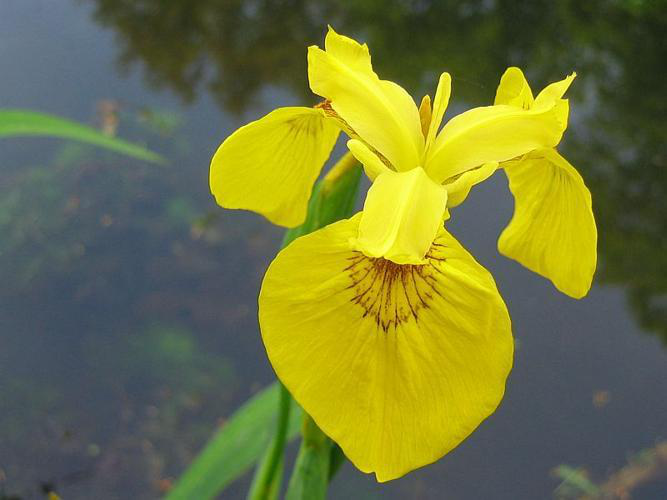

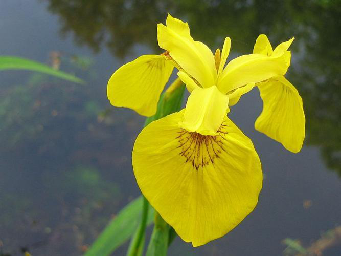

Resized image size: (341, 256)


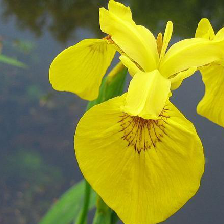

Cropped image size: (224, 224)


In [34]:
# Display original image, resized image and cropped image to confirm correct preprocessing
display(img)
display(img_resized)
print(f'Resized image size: {img_resized.size}')
display(img_cropped)
print(f'Cropped image size: {img_cropped.size}')

Note, these transformations are different to those performed on the training, validation and testing images above (we didn't center crop), meaning the the training and test images will be different to those used for inference below.  This aside, it's always important to resize prior to a center crop, and to do so larger than the center crop dimensions.

In [16]:
# Put code above into the function below

# Define function to accept an image_path and return the image as a NumPy array in format
# required by model.  Pre-processing will be conducted on image to ensure it's
# consistent with training data images
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image_path)

    # Create resized and cropped versions of image
    img_resized = return_resized_img(img)
    img_cropped = img_resized.crop((find_center_crop_coords(img_resized)))

    # Convert cropped image to a numpy array
    np_image = np.array(img_cropped)

    # Scale values between 0 and 1
    np_image = np_image / 255

    # Normalise values in same way as training data
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image-mean)/std

    np_image = np_image.transpose()
    
    return np_image
    
    
# Process a PIL image for use in a PyTorch model
np_img = process_image('flowers/train/15/image_06355.jpg')

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [17]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((2, 1, 0))    # Removed .numpy() as image was already an ndarrary
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

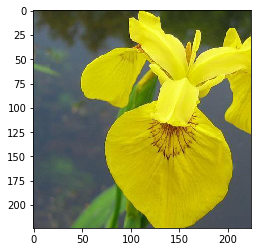

In [18]:
imshow(process_image('flowers/train/15/image_06355.jpg'))  ;

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [19]:
# Define function to accept an image path and a model and return top k probabilities and classes
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Pre-process image and convert to a float type tensor on cuda
    np_image = process_image(image_path)
    tensor_image = torch.from_numpy(np_image).to(device, dtype=torch.float)

    # Turn off gradient to speed up calculation
    with torch.no_grad():
        # Ensure model is on cuda
        model = model.to(device)
        
        # Generate predictions
        pred = torch.exp(model.forward(tensor_image.unsqueeze_(0)))
        top_k_probs = pred.topk(k=topk)[0].tolist()[0]
        top_k_indexes = pred.topk(k=topk)[1].tolist()[0]

        # Invert class-to-index dictionary
        index_to_class_map = {v:k for (k,v) in cp['class_to_idx_map'].items()}

        # Define list of top 5 prediction classes
        top_k_classes = [index_to_class_map[ind] for ind in top_k_indexes]

        return top_k_probs, top_k_classes

In [20]:
# Test function above
image_path = 'flowers/train/15/image_06355.jpg'
probs, classes = predict(image_path, model)
print(probs)
print(classes)

[0.5739032030105591, 0.22949537634849548, 0.07454618811607361, 0.0512528270483017, 0.020687619224190712]
['89', '15', '97', '80', '16']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [21]:
# Define a function to display an image along with the top 5 predicted classes for that image

def plot_flower_result(image_path):
    
    # Calculate predicted probabilities and classes for image at image_path
    probs, classes = predict(image_path, model)

    # Generate display of flower and predicted probabilities for that flower
    fig, ax = plt.subplots(figsize=(4, 8), nrows=2)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.01)

    # Display flower image
    imshow(process_image(image_path), ax=ax[0])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title(cat_to_name[image_path.split('/')[2]].capitalize(), size=14)

    # Plot probabilities for each flower class
    class_labels = [cat_to_name[c] for c in classes]
    y_pos = np.arange(len(class_labels))
    ax[1].barh(y_pos, probs, color='darkorange', edgecolor='darkorange')
    ax[1].set_yticks(y_pos)
    ax[1].set_yticklabels(class_labels)
    ax[1].invert_yaxis()
    ax[1].grid(color='lightgrey')
    ax[1].set_xlabel('\n Predicted probability', size=12)
    ax[1].set_ylabel('Predicted flower Type', size=12) ;


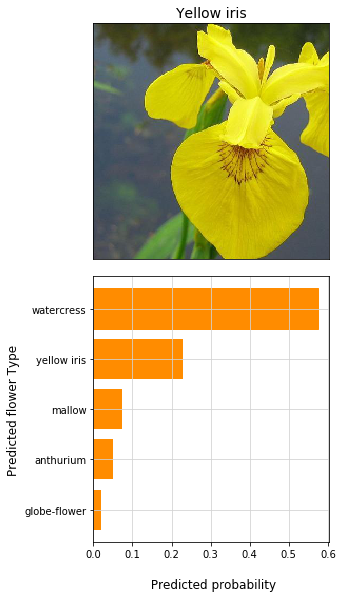

In [22]:
# Test for several flowers
plot_flower_result('flowers/train/15/image_06355.jpg')

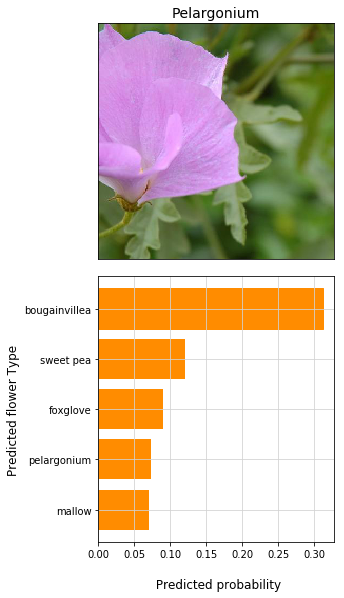

In [23]:
plot_flower_result('flowers/test/55/image_04740.jpg')

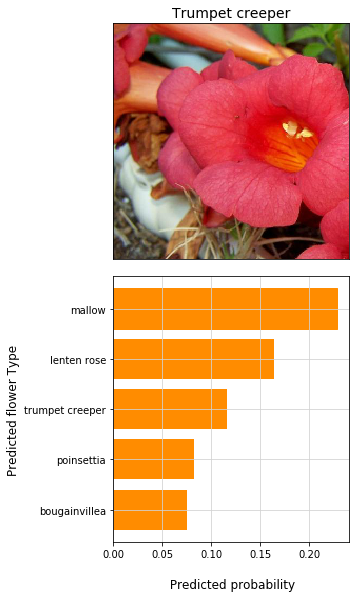

In [24]:
plot_flower_result('flowers/test/101/image_07952.jpg')

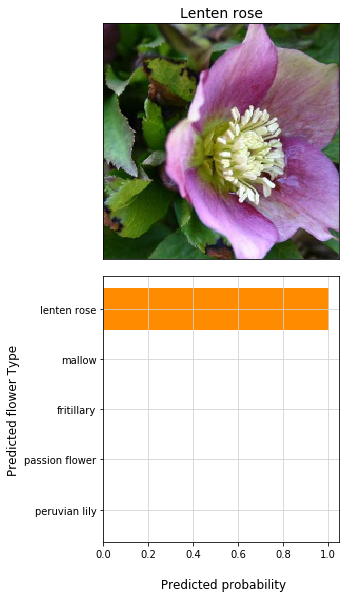

In [25]:
plot_flower_result('flowers/test/40/image_04588.jpg')

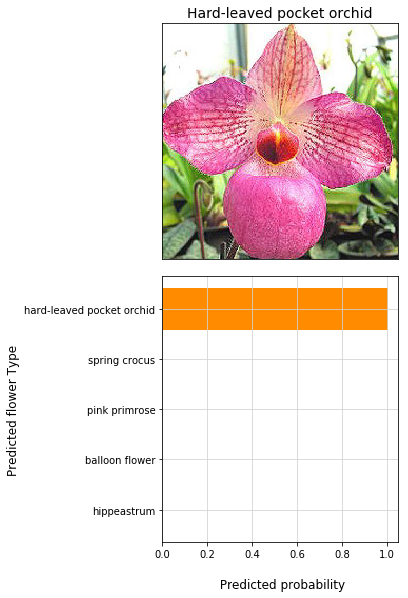

In [26]:
plot_flower_result('flowers/test/2/image_05109.jpg')

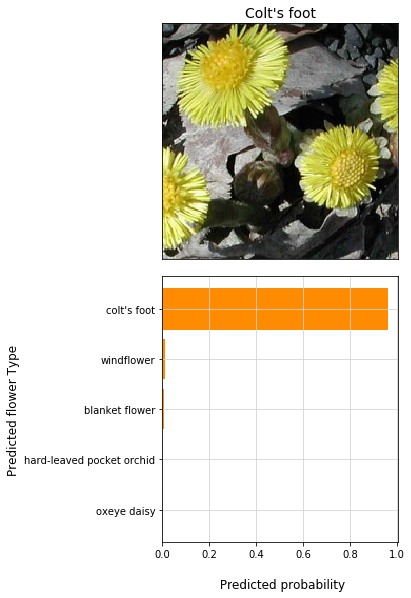

In [27]:
plot_flower_result('flowers/test/12/image_04014.jpg')

Sanity check results are OK-ish - but they appear worse than the accuracy on the test set (74.11%) calculated above would suggest.  I personally think this is because the image pre-proprocessing here is different to that performed on the test data when the model was originally trained.  E.g. For the sanity check the images were scaled differently (shortest side scaled to 256) and the image was center-cropped (as per the pre-processing instructions above), whereas the original test images were simply resized to (224,244).<br><br>I'm going to test this by adjusting the functions above to perform inference without the 256px image re-scaling and center crop...

In [28]:
def return_resized_img(img):

#     # Get image dimensions
#     img_width, img_height = img.size

#     # Calculate scaled heights and widths    
#     if img_height <= img_width:
#         scaling_factor = min_dim / img_height
#         scaled_height = int(scaling_factor * img_height)
#         scaled_width = int(scaling_factor * img_width) 
#     else: 
#         scaling_factor = min_dim / img_width
#         scaled_height = int(scaling_factor * img_height)
#         scaled_width = int(scaling_factor * img_width)

    # Return resized image, with scaled width and height    
    return img.resize((224,224))

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image_path)

    # Create resized and cropped versions of image
    img_cropped = return_resized_img(img)
    #img_cropped = img_resized.crop((find_center_crop_coords(img_resized)))

    # Convert cropped image to a numpy array
    np_image = np.array(img_cropped)

    # Scale values between 0 and 1
    np_image = np_image / 255

    # Normalise values in same way as training data
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image-mean)/std

    np_image = np_image.transpose()
    
    return np_image
    
    
# Process a PIL image for use in a PyTorch model
np_img = process_image('flowers/train/15/image_06355.jpg')

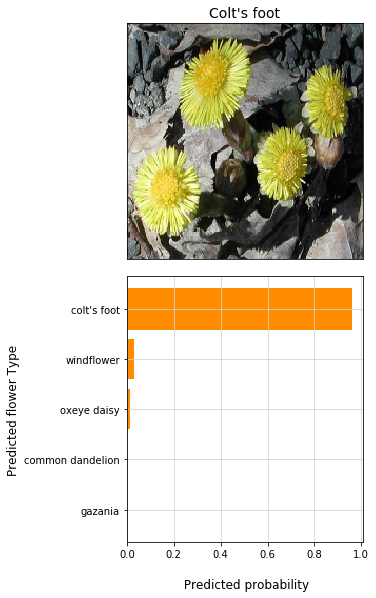

In [29]:
plot_flower_result('flowers/test/12/image_04014.jpg')

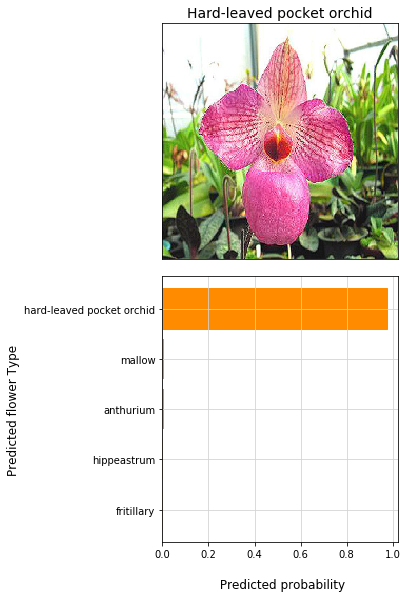

In [30]:
plot_flower_result('flowers/test/2/image_05109.jpg')

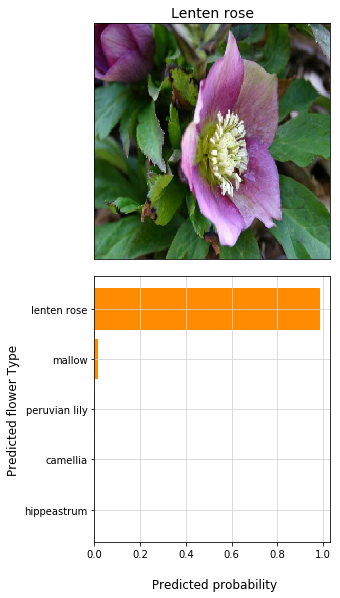

In [31]:
plot_flower_result('flowers/test/40/image_04588.jpg')

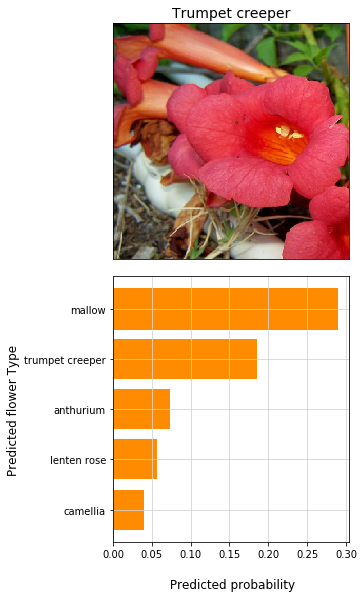

In [32]:
plot_flower_result('flowers/test/101/image_07952.jpg')

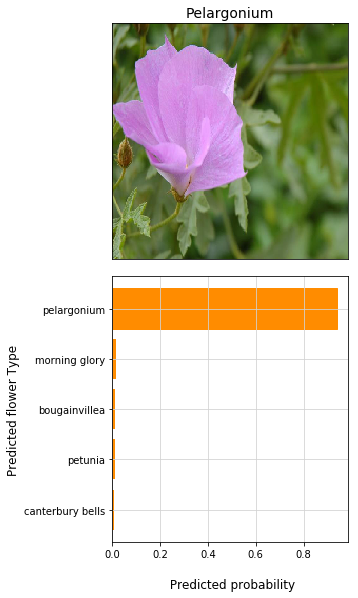

In [33]:
plot_flower_result('flowers/test/55/image_04740.jpg')

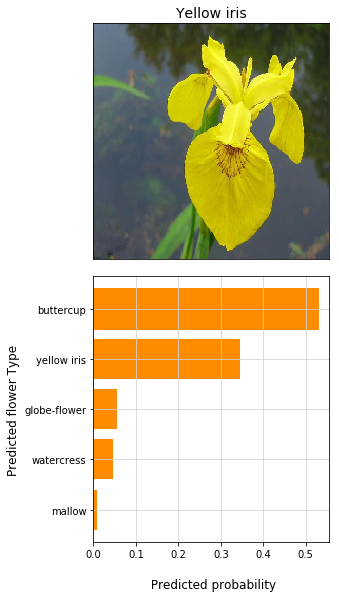

In [34]:
plot_flower_result('flowers/train/15/image_06355.jpg')

<b>The inference results appear to be a little more in-line with the accuracy calculated on the test set above.</b>